In [207]:
import PyPDF2

def extract_text_from_pdf(file_path):
    chunks = []
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text = page.extract_text()
            # Split text into chunks (e.g., paragraphs)
            paragraphs = text.split('\n\n')  # Adjust this to match your document's structure
            chunks.extend(paragraphs)  # Collect all paragraphs from the page
    return chunks




In [208]:
# Replace 'your_book.pdf' with your PDF path
pdf_chunks = extract_text_from_pdf("app_development.pdf")

In [209]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Remove non-word characters and lowercase the text
    text = re.sub(r'\W+', ' ', text.lower())
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

# Preprocess each chunk of the PDF
preprocessed_chunks = [preprocess_text(chunk) for chunk in pdf_chunks]
print(f"Processed {len(preprocessed_chunks)} chunks")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shahb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shahb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shahb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed 744 chunks


In [211]:
from gensim.models import Word2Vec

# Initialize the Word2Vec model
word2vec_model = Word2Vec(vector_size=100, window=5, min_count=2, workers=4)

# Train the model on the first batch of chunks to build the vocabulary
initial_chunks = preprocessed_chunks[:100]  # You can choose a small initial batch
word2vec_model.build_vocab(initial_chunks)
word2vec_model.train(initial_chunks, total_examples=word2vec_model.corpus_count, epochs=10)

print("Vocabulary built and initial training completed.")



Vocabulary built and initial training completed.


In [212]:
import numpy as np

def get_sentence_vector(sentence, model):
    # Get word vectors for each word in the sentence that exists in the model's vocabulary
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Generate vectors for each chunk (paragraph or page)
chunk_vectors = [get_sentence_vector(chunk, word2vec_model) for chunk in preprocessed_chunks]
print(f"Generated vectors for {len(chunk_vectors)} chunks")


Generated vectors for 744 chunks


In [216]:
chunk_vectors

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-0.04286282,  0.24776655, -0.00886436,  0.01433775,  0.06283636,
        -0.5524805 ,  0.1226714 ,  0.73660594, -0.22834246, -0.13145661,
        -0.19384253, -0.3034508 , -0.07545041,  0.23440872,  0.17628877,
        -0.28094107,  0.00232817, -0.27166685, -0.15943474, -0.61517185,
         0.13750026,  0.10501929,  0.10992246, -0.07626408, -0.15600361,
        -0.00134919, -0.24970794, -0.15607132, -0.21575135,  0.13188437,
         0.34765902, -0.07648797,  0.13547303, -0.2433374 , -0.20406385,
         0.29616502,  0.07035494, -0.31

In [220]:
len(chunk_vectors)

744

In [221]:
chunk_vectors_array = np.array(chunk_vectors)  # Convert to a numpy array if it's not already
print("Shape of chunk_vectors:", chunk_vectors_array.shape)

Shape of chunk_vectors: (744, 100)


In [215]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality of the vectors (to 2D for visualization)
pca = PCA(n_components=7)  # Reduce to 2 dimensions for visualization
reduced_vectors = pca.fit_transform(chunk_vectors)

# Print or visualize the reduced vectors
print(reduced_vectors)


[[-2.33133972e+00 -9.23880312e-03  4.97858287e-03 ...  5.02439332e-03
   8.42036199e-03  6.23550566e-04]
 [ 1.03043233e-01 -5.30898900e-03 -1.79068290e-02 ...  2.53299690e-03
   1.45563967e-02  8.70230492e-04]
 [-4.14998416e-01 -7.34149113e-03 -2.73290825e-03 ... -3.84690526e-04
   5.08140697e-03 -5.83516856e-04]
 ...
 [ 1.06958247e-01  1.60522162e-02 -6.76488483e-04 ... -1.47374392e-03
  -9.61208447e-04  1.69132917e-03]
 [ 1.78626094e-01  1.64208638e-02  1.12396298e-02 ...  9.12597717e-04
   1.22997378e-03 -3.25110653e-03]
 [ 3.45916702e-01  2.18420426e-02  3.29093517e-03 ...  5.14700897e-03
  -4.55816399e-03  6.37771085e-03]]


In [214]:
!pip install matplotlib


  Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.0.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 466.4 kB/s eta 0:00:16
   -- ------------------------------------- 0.5/7.8 MB 466.4 kB/s eta 0:00:16
   -- ------------------------------------- 0.5/7.8 MB 466.4 kB/s eta 0:00:1

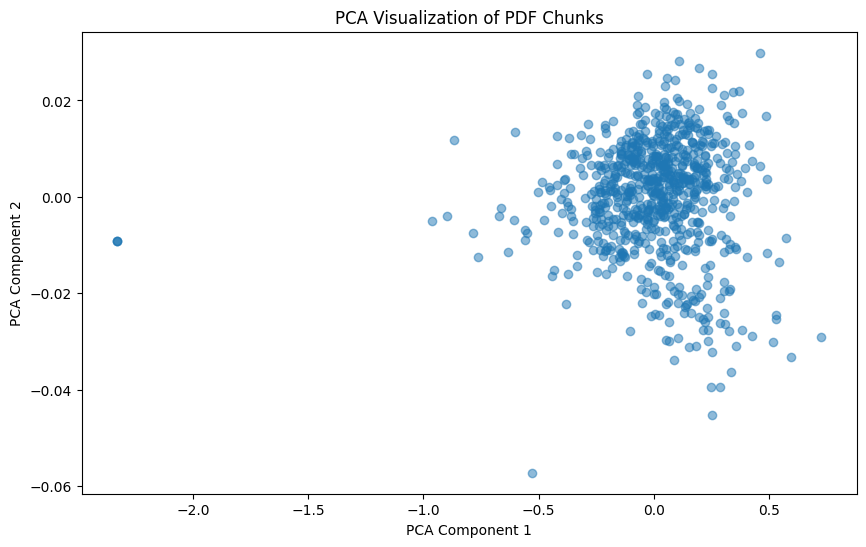

In [217]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.5)

# Optionally, you can add labels or titles for clarity
plt.title('PCA Visualization of PDF Chunks')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Show the plot
plt.show()


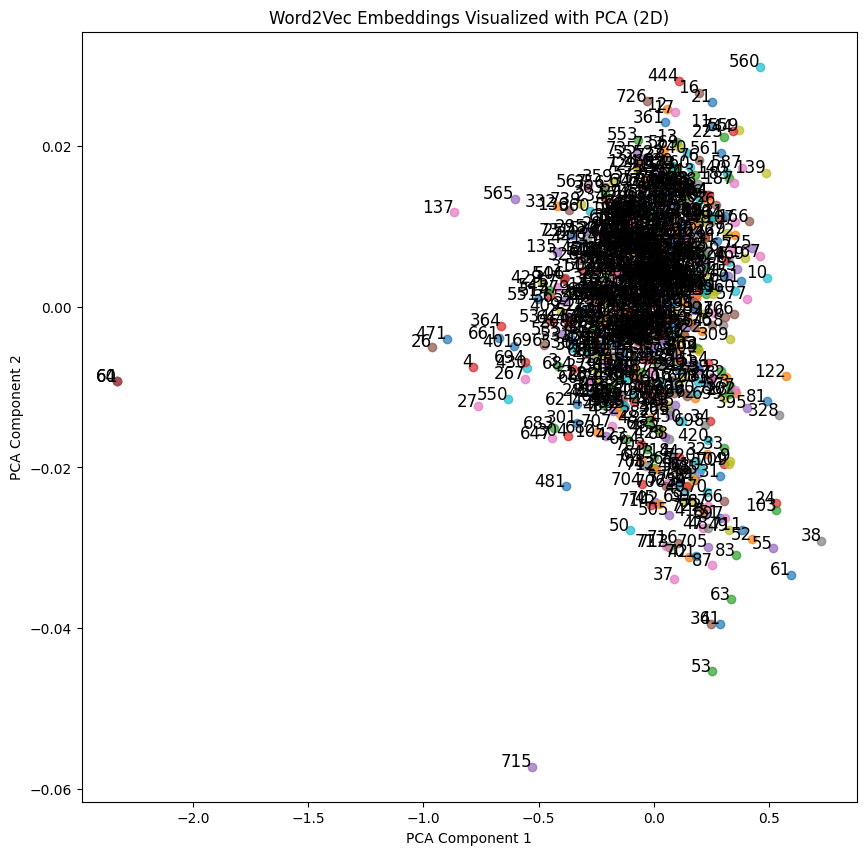

In [218]:
# Now, to visualize in 2D (the first two components)
plt.figure(figsize=(10, 10))
for i, chunk in enumerate(chunk_vectors):  # 'chunk_vectors' is the list of chunk embeddings
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], alpha=0.7)  # Plot the chunk embedding in 2D
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], str(i+1), fontsize=12, ha='right')  # Label with chunk index
# Add label to each point

# Title and labels for the axes
plt.title("Word2Vec Embeddings Visualized with PCA (2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Show the plot
plt.show()